# Spotify Genre Classification using Similarity

Batasan Masalah:

- 9 Genres: Hip Hop, Metal, Folk, Rock, Pop, Indie Rock, Country, Electronic, Blues
- bahasa inggris, bukan collab

Primary:

- id (Id of track generated by Spotify)

Numerical:

- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)

Dummy:

- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)

Categorical:

- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- artists (List of artists mentioned)
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
- name (Name of the song)

In [1]:
import nltk
from tswift import *
import random
import pandas as pd
from langdetect import detect
import requests
import heapq 

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations

import xmltodict
import pprint
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pp = pprint.PrettyPrinter(indent=4)


## 1. Load data

Terdapat 3 buah data yang perlu diunggah untuk dianalisis:

1. `data_w_genres` = Data ini menyimpan artist berserta kumpulan genrenya. Semisal artis A mempunyai musik yang masuk dalam genre Blues, Jazz dan City Pop
2. `data` = Data ini berisi kumpulan lagu berserta karakteristiknya (berdasarkan keterangan Spotify)
3. `data_by_genres` = Data ini berisi karakteristik genrenya (berdasarkan keterangan Spotify)

In [3]:
data = pd.read_csv('data/spotify_dataset_kg/data_w_genres.csv')
data_song = pd.read_csv('data/spotify_dataset_kg/data.csv')
data_genres = pd.read_csv('data/spotify_dataset_kg/data_by_genres.csv')

In [6]:
data.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,[]


In [7]:
data_song.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [8]:
data_genres.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32539 entries, 0 to 32538
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           32539 non-null  object 
 1   acousticness      32539 non-null  float64
 2   danceability      32539 non-null  float64
 3   duration_ms       32539 non-null  float64
 4   energy            32539 non-null  float64
 5   instrumentalness  32539 non-null  float64
 6   liveness          32539 non-null  float64
 7   loudness          32539 non-null  float64
 8   speechiness       32539 non-null  float64
 9   tempo             32539 non-null  float64
 10  valence           32539 non-null  float64
 11  popularity        32539 non-null  float64
 12  key               32539 non-null  int64  
 13  mode              32539 non-null  int64  
 14  count             32539 non-null  int64  
 15  genres            32539 non-null  object 
dtypes: float64(11), int64(3), object(2)
memo

In [10]:
data_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [11]:
data_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            3232 non-null   object 
 1   acousticness      3232 non-null   float64
 2   danceability      3232 non-null   float64
 3   duration_ms       3232 non-null   float64
 4   energy            3232 non-null   float64
 5   instrumentalness  3232 non-null   float64
 6   liveness          3232 non-null   float64
 7   loudness          3232 non-null   float64
 8   speechiness       3232 non-null   float64
 9   tempo             3232 non-null   float64
 10  valence           3232 non-null   float64
 11  popularity        3232 non-null   float64
 12  key               3232 non-null   int64  
 13  mode              3232 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 353.6+ KB


In [12]:
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,32539.000000,32539.000000,3.253900e+04,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000
mean,0.455682,0.552737,2.485982e+05,0.525908,0.233281,0.209035,-11.008171,0.092047,117.433745,0.498812,24.473452,5.459787,0.734903,12.561818
std,0.383678,0.176445,1.581808e+05,0.267402,0.334487,0.151781,5.568630,0.111257,24.467506,0.247154,23.021041,3.473653,0.441392,52.407821
min,0.000000,0.000000,8.042000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.055155,0.436487,1.804616e+05,0.299000,0.000012,0.109000,-13.792500,0.039700,100.983500,0.305792,0.000000,2.000000,0.000000,2.000000
50%,0.391833,0.563000,2.215070e+05,0.537375,0.009550,0.162000,-9.887000,0.052822,118.779000,0.506000,22.666667,6.000000,1.000000,2.000000
75%,0.876000,0.684500,2.815870e+05,0.747039,0.451149,0.259500,-6.944500,0.090800,130.552000,0.691500,43.141941,8.000000,1.000000,7.000000
max,0.996000,0.987000,4.696690e+06,1.000000,1.000000,0.986000,3.367000,0.971000,219.833000,0.997000,94.000000,11.000000,1.000000,3179.000000


In [13]:
data_song.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


In [14]:
data_genres.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
count,3232.000000,3232.000000,3.232000e+03,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,0.368161,0.540810,2.614567e+05,0.583474,0.254888,0.204010,-10.396208,0.084999,119.707549,0.483757,29.701618,5.942450,0.819926
std,0.319697,0.149353,1.255810e+05,0.232931,0.283907,0.103440,5.024042,0.081157,17.333590,0.200382,18.415394,3.342851,0.384309
min,0.000001,0.063200,3.094600e+04,0.000953,0.000000,0.016500,-40.637000,0.024300,61.364269,0.019285,0.000000,0.000000,0.000000
25%,0.082914,0.450250,2.068497e+05,0.419648,0.013383,0.142317,-12.212486,0.046431,109.480352,0.341571,15.190070,3.000000,1.000000
50%,0.280119,0.550334,2.418786e+05,0.622982,0.128343,0.185618,-9.097583,0.060769,120.142000,0.488364,32.181281,7.000000,1.000000
75%,0.629265,0.645470,2.873741e+05,0.756599,0.443383,0.233807,-7.038634,0.091795,128.253833,0.626171,43.069058,9.000000,1.000000
max,0.996000,0.940000,3.478338e+06,0.999000,0.984000,0.944000,-0.862000,0.956000,211.968000,0.997000,79.000000,11.000000,1.000000


In [15]:
for gr in data_genres.genres.values:
    print(gr)

21st century classical
432hz
8-bit
[]
a cappella
abstract
abstract beats
abstract hip hop
abstract idm
accordeon
accordion
acid house
acid jazz
acid rock
acid techno
acid trance
acousmatic
acoustic blues
acoustic chill
acoustic guitar cover
acoustic pop
acoustic punk
acoustic rock
action rock
adoracao
adoracion
adult standards
adventista
afghan pop
afghan traditional
african gospel
african percussion
african reggae
african rock
african-american classical
afrikaans
afro dancehall
afro house
afro psych
afro-funk
afrobeat
afrofuturism
afrofuturismo brasileiro
afropop
afroswing
aggrotech
alabama indie
alabama metal
alabama rap
alaska indie
albanian hip hop
albanian pop
alberta country
alberta hip hop
album rock
albuquerque indie
alternative americana
alternative country
alternative dance
alternative emo
alternative hip hop
alternative metal
alternative pop
alternative pop rock
alternative r&b
alternative rock
alternative roots rock
amapiano
ambeat
ambient
ambient black metal
ambient dub te

Kumpulan kemunculan kata unik dari seluruh genre

In [16]:
all_genres = ''
for index, row in data_genres.iterrows():
    all_genres += f' {row.genres}'
words = nltk.tokenize.word_tokenize(all_genres)
fdist1 = nltk.FreqDist(words)
filtered_word_freq = dict((word, freq) for word, freq in fdist1.items() if not word.isdigit())

# pp.pprint(filtered_word_freq)

In [17]:
 sorted_freq=dict(sorted(filtered_word_freq.items(), key=lambda item: item[1], reverse=True))
#  pp.pprint(sorted_freq)

Contoh: melihat genre lagu yang mengandung kata *deep*

In [18]:
data_genres[data_genres.genres.str.contains('deep')]

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
840,deep acoustic pop,0.085264,0.489400,228905.600000,0.703600,0.006198,0.285000,-7.945400,0.050060,127.899200,0.456400,14.000000,7,0
841,deep adult standards,0.748842,0.534445,161690.311559,0.353420,0.010722,0.219448,-10.910108,0.058916,114.193997,0.597030,22.538274,7,1
842,deep big room,0.062247,0.584321,291623.708419,0.841652,0.306751,0.252796,-5.733017,0.083508,129.741124,0.354512,15.052478,7,0
843,deep ccm,0.280608,0.465417,363936.109548,0.525769,0.029741,0.208666,-8.719539,0.071184,129.831618,0.310890,42.679028,7,1
844,deep chill,0.759000,0.653000,325438.000000,0.552000,0.894000,0.094800,-16.761000,0.049600,116.988000,0.398000,0.000000,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,deep techno,0.024422,0.729375,397985.000000,0.727875,0.697175,0.310000,-10.324625,0.064638,123.001125,0.288350,1.125000,9,1
906,deep tropical house,0.189536,0.668630,235391.872396,0.698063,0.251794,0.176935,-7.231820,0.052642,112.049148,0.416335,30.119792,5,1
907,deep underground hip hop,0.164410,0.719550,206514.095614,0.680921,0.000056,0.212142,-6.907937,0.187060,126.263554,0.412374,54.008772,5,0
908,deep uplifting trance,0.017665,0.603742,212674.871765,0.866087,0.513248,0.237798,-7.276036,0.070537,130.420658,0.486629,5.111123,7,0


Melakukan filtering untuk semua genre yang panjang teksnya lebih dari 3

In [19]:
data_clean = data[data['genres'].str.len() >= 3]

In [20]:
def string_to_list(text):
    text = text.replace("[","").replace("'", "").replace("'", "").replace("]", "")
    return text.split(", ")


In [21]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [22]:
genres = set()
for index, row in data_clean.iterrows():
    genres |= set(string_to_list(row['genres']))

Pengelompokan genre berdasarkan induknya. Data diambil dari artikel pada Wikipedia, dimana ada keterangan dari mana genre tersebut muncul. Ada beberapa penyesuaian, seperti indie bisa masuk pada genre *folk* dan *rock*, namun karena berdasarkan pencarian lebih banyak masuk pada *rock*.

In [23]:
SELECTED_GENRES = ['Hip Hop', 'Metal', 'Folk', 'Rock', 'Punk', 'Country', 'Electronic', 'Blues', 'Jazz', 'Pop', 'Reggae']
hip_hop_genres = ['rap', 'funk', 'hip', 'hop']
metal_genres = ['metalcore', 'metal']
folk_genres =  ['banjo', 'folk']
rock_genres =  ['beat', 'roll', 'indie', 'rock']
punk_genres = ['grindcore', 'emo', 'punk']
electronic_genres= ['techno', 'idm', 'house', 'edm', 'disco', 'synthpop', 'tropical', 'electronic']
blues_genres = ['r&b', 'soul', 'blues']
pop_genres =  ['electropop', 'new wave', 'pop']
jazz_genres =  ['jazz']
reggae_genres = ['reggae']
country_genres = ['country']

In [24]:
def check_genres(genres):
    for item in genres:
        for gr in SELECTED_GENRES:
            gr = gr.replace(" ", "").lower()
            item = item.replace(" ", "").lower()
            if item.__contains__(gr):
                return True
    return False

Method taksonomi untuk mengambil genre terdekat dari input genre. Sederhananya jika judul genre ini memiliki keterangan sesuai pada taksonomi, maka masuk pada genre tersebut

In [25]:
def normalized_genre(genre):
    for gr in SELECTED_GENRES:
        grs = gr.lower()
        itemk = genre.lower()
        if [gn for gn in hip_hop_genres if(gn in itemk)]:
            return 'Hip Hop'
        if [gn for gn in metal_genres if(gn in itemk)]:
            return 'Metal'
        if [gn for gn in folk_genres if(gn in itemk)]:
            return 'Folk'
        if [gn for gn in rock_genres if(gn in itemk)]:
            return 'Rock'
        if [gn for gn in punk_genres if(gn in itemk)]:
            return 'Punk'
        if [gn for gn in country_genres if(gn in itemk)]:
            return 'Country'
        if [gn for gn in electronic_genres if(gn in itemk)]:
            return 'Electronic'
        if [gn for gn in blues_genres if(gn in itemk)]:
            return 'Blues'
        if [gn for gn in jazz_genres if(gn in itemk)]:
            return 'Jazz'
        if [gn for gn in pop_genres if(gn in itemk)]:
            return 'Pop'
        if [gn for gn in reggae_genres if(gn in itemk)]:
            return 'Reggae'
    return False

Method untuk mengambil liriknya

In [26]:
def get_lyrics(artist, song):
    try:
        url = "http://api.chartlyrics.com/apiv1.asmx/SearchLyricDirect"
        querystring = {"artist":artist,"song":song}
        response = requests.request("GET", url, params=querystring)
        docs = xmltodict.parse(response.text)
        return docs['GetLyricResult']['Lyric']
    except Exception as e:
        return None

In [27]:
def check_is_english_song(lyric):
    return detect(lyric) =='en' 

In [28]:
len(genres)

3231

## 2. Membersihkan data

Tahap ini memproses semua data yang ada pada data genre. Pertama yang dilakukan adalah membuat kolom kosong dengan keterangan `Not Classified`. Kemudian diisi dengan genre terdekat menggunakan metode taksonomi di atas.

In [29]:
cleaned_genre = data_genres.copy()
cleaned_genre['normalized_genre'] = 'Not Classified'
for index, row in cleaned_genre.iterrows():
    new_genre = normalized_genre(row.genres)
    if (new_genre):
        cleaned_genre.loc[cleaned_genre.genres==row.genres, "normalized_genre"] = new_genre
# cleaned_genre=cleaned_genre[cleaned_genre.normalized_genre.notnull()]

In [30]:
cleaned_genre.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,normalized_genre
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1,Not Classified
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1,Not Classified
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1,Not Classified
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1,Not Classified
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1,Not Classified


In [31]:
cleaned_genre.normalized_genre.unique()

array(['Not Classified', 'Rock', 'Hip Hop', 'Electronic', 'Jazz', 'Blues',
       'Pop', 'Punk', 'Reggae', 'Metal', 'Country', 'Folk'], dtype=object)

In [32]:
len(cleaned_genre)

3232

In [33]:
cleaned_genre = cleaned_genre.drop(columns=['key', 'mode', 'popularity'])

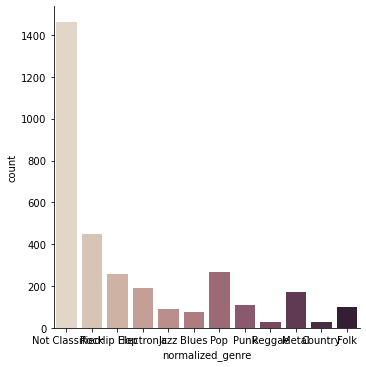

In [34]:
sns.catplot(x="normalized_genre", kind="count", palette="ch:.25", data=cleaned_genre)

In [35]:
cleaned_genre.groupby('normalized_genre')['genres'].nunique()

normalized_genre
Blues               76
Country             30
Electronic         192
Folk               100
Hip Hop            258
Jazz                92
Metal              170
Not Classified    1463
Pop                265
Punk               109
Reggae              27
Rock               450
Name: genres, dtype: int64

In [36]:
cleaned_genre.corr().abs()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.000000,0.313905,0.087727,0.869606,0.088735,0.086465,0.727258,0.046420,0.412295,0.107280
danceability,0.313905,1.000000,0.045795,0.281404,0.244617,0.174051,0.413898,0.219735,0.140094,0.586904
duration_ms,0.087727,0.045795,1.000000,0.014236,0.254552,0.010243,0.090775,0.022794,0.002845,0.242138
energy,0.869606,0.281404,0.014236,1.000000,0.154197,0.193163,0.842509,0.088189,0.428856,0.228205
instrumentalness,0.088735,0.244617,0.254552,0.154197,1.000000,0.064651,0.405030,0.183492,0.061999,0.439943
liveness,0.086465,0.174051,0.010243,0.193163,0.064651,1.000000,0.148566,0.177949,0.003905,0.048904
loudness,0.727258,0.413898,0.090775,0.842509,0.405030,0.148566,1.000000,0.064439,0.393310,0.344053
speechiness,0.046420,0.219735,0.022794,0.088189,0.183492,0.177949,0.064439,1.000000,0.013008,0.083281
tempo,0.412295,0.140094,0.002845,0.428856,0.061999,0.003905,0.393310,0.013008,1.000000,0.117167
valence,0.107280,0.586904,0.242138,0.228205,0.439943,0.048904,0.344053,0.083281,0.117167,1.000000


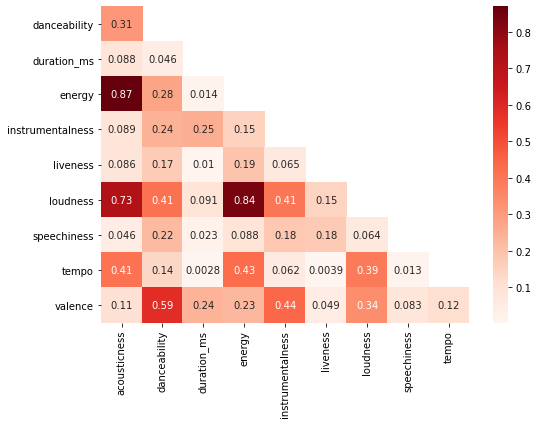

In [37]:
fig, ax = plt.subplots(figsize=(8,6))

corr = cleaned_genre.corr().abs()

# Set a 'mask' for the upper half of the heatmap. 
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Reds', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, ha="center",)
plt.setp(ax.get_yticklabels(), rotation=0)

# Hack to fix the cutoff squares and remove empty row and column. 
ax.set_ylim(len(corr), 1)
ax.set_xlim(xmax=len(corr)-1)

fig.tight_layout()

In [38]:
# Check the correlation value of numerical variable with the genres (classes)
filter_cols = ['acousticness', 'danceability', 'energy', 'duration_ms', 'instrumentalness', 'valence', 'tempo', 'liveness', 'loudness', 'speechiness']


In [39]:
cleaned_genre.iloc[:,1:-1].columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')

In [40]:
# - acousticness (Ranges from 0 to 1)
# - danceability (Ranges from 0 to 1)
# - energy (Ranges from 0 to 1)
# - duration_ms (Integer typically ranging from 200k to 300k) -> Tidak dipakai
# - instrumentalness (Ranges from 0 to 1)
# - valence (Ranges from 0 to 1)
# - popularity (Ranges from 0 to 100) -> Tidak dipakai
# - tempo (Float typically ranging from 50 to 150)
# - liveness (Ranges from 0 to 1)
# - loudness (Float typically ranging from -60 to 0)
# - speechiness (Ranges from 0 to 1)


## 3. Mengambil lirik lagu

Tahap ini mengambil lirik lagu sekaligus menyaring data. Data disaring berdasarkan:

1. Jika liriknya tidak ada maka dibuang
2. Jika liriknya bukan berbahasa Inggris maka dibuang
3. Jika tidak ada keterangan genrenya maka dibuang
4. Jika genrenya tidak ada dalam kelompok 11 genre besar, maka dibuang
5. Jika genrenya termasuk dalam `Not Classified` maka dibuang

In [41]:
COUNT_DATA = 0
LIMITS = 15000
new_data  = {
    'artist':[], 
    'song_name': [],
    'closest_genre': [],
    'lyric':[],
    }
for index, row in data_song.iterrows():
    if COUNT_DATA >=LIMITS:
        break
    try:
        artist_name = row['artists'].replace('[','').replace(']', '').replace("'",'')
        artist_data = data_clean[data_clean.artists.str.contains(artist_name)]
        song_name = row['name']
        print(artist_name,'-',song_name, '-', check_genres(artist_data.genres))
        lyric = get_lyrics(artist_name, song_name)
        if lyric == None:
            continue
        if not (check_is_english_song(lyric)):
            continue
        if len(artist_data.genres)<1:
            continue
        temp_similarity_mat = {}
        temp_l = string_to_list(artist_data.genres.values[0])
        if len(cleaned_genre[cleaned_genre.genres.isin(temp_l)])<1:
            continue
        for _, rowk in cleaned_genre[cleaned_genre.genres.isin(temp_l)].iterrows():
            temp_similarity_mat[rowk.genres] = cosine_similarity(rowk[filter_cols].to_numpy(), artist_data[filter_cols].to_numpy()[0])
        top_genre = heapq.nlargest(1, temp_similarity_mat)
        closest_genre = cleaned_genre[cleaned_genre.genres.isin(top_genre)].normalized_genre.values[0]
        if closest_genre == 'Not Classified':
            continue
        new_data['artist'].append(artist_name)
        new_data['song_name'].append(song_name)
        new_data['lyric'].append(lyric)
        new_data['closest_genre'].append(closest_genre)
        COUNT_DATA +=1
    except Exception as e:
        continue
    
    

In [42]:
song_genres = pd.DataFrame(new_data)
song_genres.to_csv(f'song_genres_{COUNT_DATA}.csv')